# Tutorial : 10x Visium(DLPFC dataset)

Here, we present our re-analysis of sample 151676 from the dorsolateral prefrontal cortex (DLPFC) dataset. In the original study by Maynard et al., the DLPFC layers and white matter (WM) were manually annotated based on morphological features and gene markers.

In [1]:
import os
os.environ['R_HOME']="/share/home/baixiaosheng/software/anaconda/envs/r_env/lib/R"
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from dec import DEC as E
from data import spatial_reconstruction, refine_label, setup_seed
from sklearn.metrics.cluster import adjusted_rand_score


2024-09-06 10:26:52.712851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 10:26:52.853879: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 10:26:53.516400: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/libfabric/1.13.0/lib:/opt/ohpc/pub/mpi/ucx-ohpc/1.11.2/lib:/opt/ohpc/

In [2]:
adata = ad.read_h5ad('./151675.h5ad')

In [3]:
adata, conns = spatial_reconstruction(adata,alpha=1.0)
features_tensor = torch.tensor(adata.obsm['expression_embedding']).float()
relations_tensor = torch.tensor(conns).float()

In [14]:
setup_seed(33)
n_clusters = 7
radius = 50

epoch = 20
clf=E(features_tensor,relations_tensor,node_width=features_tensor.shape[1], edge_width=relations_tensor.shape[0],num_heads=5,nhid=30,n_clusters=n_clusters,epochs=epoch)

#Run
a = clf.fit(features_tensor,relations_tensor, init="mclust",num_cluster=n_clusters,n_neighbors=30,pca_num=30)
y_pred, prob,z1=clf.predict() 

adata.obs["pred"] = y_pred
adata.obs["pred"] = adata.obs["pred"].astype('category')

fitting ...
  |======================================================================| 100%


In [15]:
adata, refine = refine_label(adata, radius=radius,key='pred')

In [28]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['annotation'], obs_df['pred'])
print('Adjusted rand index = %.3f' %ARI)
refine_ARI = adjusted_rand_score(obs_df['annotation'], obs_df['label_refined'])
print('refine Adjusted rand index = %.3f' %refine_ARI)

Adjusted rand index = 0.550
refine Adjusted rand index = 0.560


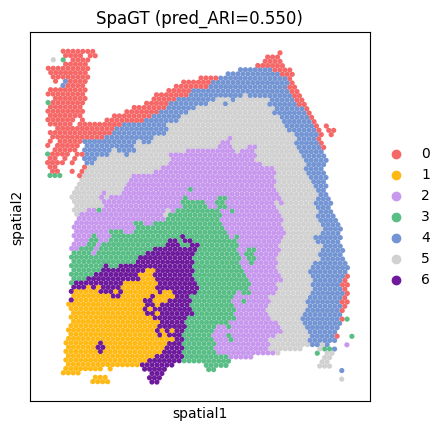

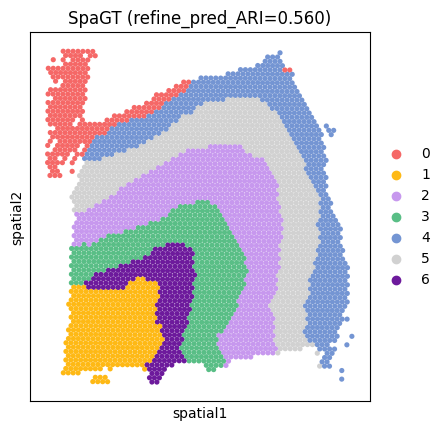

In [26]:
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
    
sc.pl.spatial(
    adata,
    img_key=None,
    color='pred',
    size=1.5,
    palette=plot_color,
    legend_loc='right margin',
    show=False,
    title=['SpaGT (pred_ARI=%.3f)'%ARI]
)

sc.pl.spatial(
    adata,
    img_key=None,
    color='label_refined',
    size=1.5,
    palette=plot_color,
    legend_loc='right margin',
    show=False,
    title=['SpaGT (refine_pred_ARI=%.3f)'%refine_ARI]
)

plt.show()